<a href="https://colab.research.google.com/github/jeaho2641/datamining3/blob/master/titanic_prac2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster

In [3]:
# 데이터 분석
import pandas as pd
import numpy as np
import random as rnd

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 기계 학습
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 데이터 로딩 및 확인

In [0]:
# 데이터 로딩
train_df = pd.read_csv('/content/drive/My Drive/데이터마이닝/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/데이터마이닝/test.csv')
combine = [train_df, test_df]

In [0]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [0]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
# preview tail of the data
train_df.tail()

In [0]:
train_df.info()
print('_'*40)
test_df.info()

In [0]:
train_df.describe()

## Missing Value 처리

In [0]:
# check missing values in train dataset
train_df.isnull().sum()

In [0]:
test_df.isnull().sum()

###### 속성에 값이 없는 샘플들이 존재. 그 중 Age, Cabin에 missing value(누락값)가 많이 발견됨 전체에서 몇프로나 차지하는 지 확인해보자.

In [0]:
# Age에 누락값이 있는 샘플의 비율
sum(pd.isnull(train_df['Age']))/len(train_df["PassengerId"])

0.19865319865319866

In [0]:
# Cabin에 누락값이 있는 샘플의 비율
sum(pd.isnull(train_df['Cabin']))/len(train_df["PassengerId"])

0.7710437710437711

###### Age는 20%의 샘플에서 누락, Cabin은 77%의 샘플에서 누락. Age는 누락된 값을 채워넣고, Cabin은 아예 feature를 버리는게 낫겠다.

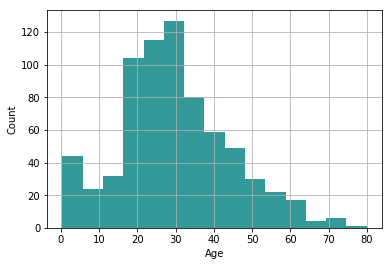

In [0]:
# Age가 어떻게 분포되어 있는지 히스토그램으로 확인해보자.
ax = train_df["Age"].hist(bins=15, color='teal', alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [0]:
# 그럼 Age의 중간값은 얼마일까?
train_df["Age"].median(skipna=True)

###### 누락된 값들에 그냥 중간값을 일괄적으로 채워넣는 것이 좋아보인다. 남은 것은 train에서 Embarked, test에서 Fare

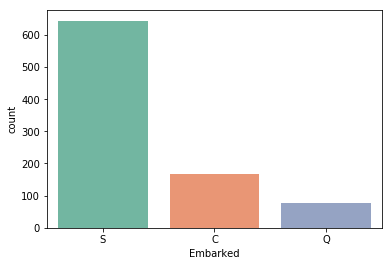

In [0]:
# train set에서 Embarked 의 분포를 확인해보자.
sns.countplot(x='Embarked',data=train_df,palette='Set2')
plt.show()

In [0]:
# Fare는 가격, 그럼 평균값은?
train_df["Fare"].mean(skipna=True)

###### Embarked는 S가 가장 많으니 누락값에 S를 채워넣으면 무난하겠다.
###### Fare는 승선한 항구와 티켓 등급에 따라 다르겠지만 편이상 평균값인 32를 취해서 누락값에 넣는 것을 채택하겠다.

## 데이터 전처리: 속성에 따라 누락된 값을 채워 넣거나 속성 자체 제거

In [0]:
# 누락된 값을 적절한 값으로 채워넣기
train_df["Age"].fillna(28, inplace=True)
test_df["Age"].fillna(28, inplace=True)
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"].fillna(32, inplace=True)

# 누락된 값이 너무 많은 속성 제거
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

## 데이터 속성별 값에 따라 생존자 확인


In [0]:
# 객실 등급에 따른 생존자 확률
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [0]:
# 성별에 따른 생존자 확률
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [0]:
# 가족, 친척의 명수에 따른 생존자 확률
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [0]:
# 부모자식 관계에 있는 사람의 명수에 따른 생존자 확률
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

## 데이터 시각화

In [0]:
# 나이별 비생존자와 생존자
g = sns.FacetGrid(train_df, col='Survived') # 열에 생존자 0/1 
g.map(plt.hist, 'Age', bins=20)

In [0]:
# 나이별 객실 등급별 비생존자와 생존자
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6) # 열에 생존자, 행에 객실 등급 
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [0]:
#이번에는 히스토그램이 아닌 꺾은선 그래프
grid = sns.FacetGrid(train_df, col='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1, 2, 3], hue_order=None)
grid.add_legend()

## 데이터 전처리: 속성 조정

In [0]:
# 우선 현재 보유하고 있는 속성을 다시 한 번 확인해보자
train_df.head()

###### 속성 조정
1. PassengerId는 샘플별로 다르기 때문에 제거
2. Survived 는 예측해야할 output
3. Age, Fare는 그대로 채택
4. Sex, Pclass, Embarked는 카테고리 값이므로 처리.
5. SibSp, Parch 는 Binary 값으로 수정
6. Ticket은 표 번호이므로 상관성이 거의 없는 값이라 제거
7. Name은 한 번 살펴볼 것.

### 데이터 전처리 : 속성 조정 - SibSp, Parch 는 Binary 값으로 수정

In [0]:
# 신규 속성인 TravelSibSp, TravelParch 만들어줌
# 해당 속성이 0보다 크면 1, 아니면 0
train_df['TravelSibSp'] = np.where(train_df['SibSp']>0, 1, 0)
train_df['TravelParch'] = np.where(train_df['Parch']>0, 1, 0)
# 이후 SibSp, SibSp 제거
train_df.drop('SibSp', axis=1, inplace=True)
train_df.drop('Parch', axis=1, inplace=True)

In [0]:
# test 데이터도 마찬가지로 적용
test_df['TravelSibSp'] = np.where(test_df['SibSp']>0, 1, 0)
test_df['TravelParch'] = np.where(test_df['Parch']>0, 1, 0)
test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)

### 데이터 전처리 : 속성 조정 - 카테고리 속성인 Pclass, Embarked, Sex 처리

어떻게? Pclass에 세 가지가 있으니 Pclass 라는 속성을 세 개로 쪼갠다. Pclass_1, Pclass_2, Pclass_3

Embarked도 마찬가지. S, C, Q 가 있으니 Embarked_S, Embarked_C, Embarked_Q

Sex도 마찬가지, female, male 이 있으니 Sex_female, Sex_femal

In [0]:
# Pcalss를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df2)
train_df2 = pd.get_dummies(train_df, columns=["Pclass"])

# Embarked를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df3)
train_df3 = pd.get_dummies(train_df2, columns=["Embarked"])

# Sex를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df3)
train_df4 = pd.get_dummies(train_df3, columns=["Sex"])

# 결과 확인
train_df4.head()

###### 그런데 여기서, Sex_female, Sex_male 이 모두 필요할까? 어짜피 같은 정보를 갖고 있으므로 둘 중 하나만 있으면 되지 않는가? 따라서 둘 중 하나를 삭제


### 데이터 전처리 : 속성 조정 - 쓸모없는 속성 제거

In [0]:
train_df4.drop('PassengerId', axis=1, inplace=True)
train_df4.drop('Name', axis=1, inplace=True)
train_df4.drop('Ticket', axis=1, inplace=True)
train_df4.drop('Sex_male', axis=1, inplace=True)
train_df4.head()

### 데이터 전처리 : 위의 속성 조정을 이젠 test_df에도 모두 해주자

In [0]:
test_df2 = pd.get_dummies(test_df, columns=["Pclass"])
test_df3 = pd.get_dummies(test_df2, columns=["Embarked"])
test_df4 = pd.get_dummies(test_df3, columns=["Sex"])

#test_df4.drop('PassengerId', axis=1, inplace=True) <--- 이건 나중에 평가를 위해 일단 지금은 지우지 말자
test_df4.drop('Name', axis=1, inplace=True)
test_df4.drop('Ticket', axis=1, inplace=True)
test_df4.drop('Sex_male', axis=1, inplace=True)
test_df4.head()

###### 이제 드디어 데이터 준비는 모두 끝났다!!!!!!!!

# Machine Learning 기법을 활용한 생존자 예측
## 활용 모델

Logistic Regression

k-Nearest Neighbors

Support Vector Machines

Naive Bayes classifier

Decision Tree

Artificial neural network

In [0]:
# 우선 학습 집합과 테스트 집합을 준비한다.
X_train = train_df4.drop("Survived", axis=1)
Y_train = train_df4["Survived"]
X_test  = test_df4.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

## Support Vector Machines

In [0]:
# SVM 모델 학습
svc = SVC()
svc.fit(X_train, Y_train)

In [0]:
# 테스트 데이터에 대해 예측
Y_pred_svc = svc.predict(X_test)
# 테스트 데이터를 현재 레이블이 없으므로 학습 데이터에 대해 예측한 정확도 측정
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

## Logistic Regression

In [0]:
# Logistic Regression training
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

In [0]:
# Logistic Regression prediction
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.scroe(X_train, Y_train) * 100, 2) # training 데이터에 대해 예측 정확도 구함
acc_log

In [0]:
# 속성별 상관 계수
coeff_df  =  pd.DataFrame(train_df4.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

## k-Nearest Neighbor

In [0]:
knn  = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

## Naive Bayes classifiers

In [0]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_NB = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

## Decision tree

In [0]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DT = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

## Artificial Neural Network

In [0]:
ANN = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(10, 30), random_state=1)
ANN.fit(X_train, Y_train)
Y_pred_ANN = ANN.predict(X_test)
acc_ANN = round(ANN.score(X_train, Y_train) * 100, 2)
acc_ANN

## 최종 결과 저장

In [0]:
Y_pred = Y_pred_DT

submission = pd.DataFrame({
        "PassengerId": test_df4["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./data/submission.csv', index=False)